In [1]:
import cnot_network

from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sbs
import numpy as np
sbs.set_context("paper")
sbs.set_theme()
sbs.set_style("dark")
sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

In [2]:
def plt_data(condition, x_axis, y_axis, target=None):
    data = filter(lambda x: x[0] == target, zip(condition, x_axis, y_axis))
    x = []
    y = []
    for _, x_val, y_val in data:
        x.append(x_val)
        y.append(y_val)
    return {'x':x, 'y':y}   

In [3]:
n_rounds = 5
counts = 6
repeats = 5
heights = range(8, 65, 2)

In [4]:
from functools import partial
from surface_code_routing.lib_instructions import T_Factory, Toffoli, T_gate

toff_height = 14
toff_width = toff_height

qcb_size = 20

t_factory_l1 = cnot_network.T_Factory()
toffoli_gate = cnot_network.Toffoli

t_factory_l2 = T_Factory(t_factory_l1, height=8, width=10, t_gate=T_gate(t_factory_l1))
t_gate_l2 = T_gate(factory=t_factory_l2)

t_factory_l3 = T_Factory(t_factory_l2, height=11, width=12, t_gate=T_gate(t_factory_l2))
t_gate_l3 = T_gate(factory=t_factory_l3)

extern_toffoli_l1 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l1)
extern_toffoli_l2 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l2)
extern_toffoli_l3 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l3)

# Raw T injection sites
ccz_factory_l1 = cnot_network.CCZ_factory(6, 4, t_factory=None)
ccz_factory_l2 = cnot_network.CCZ_factory(9, 7, t_factory=t_factory_l1)
ccz_factory_l3 = cnot_network.CCZ_factory(11, 11, t_factory=t_factory_l2)

t_factories = (t_factory_l1, t_factory_l2, t_factory_l3)
extern_toffolis = (extern_toffoli_l1, extern_toffoli_l2, extern_toffoli_l3)
ccz_factories = (ccz_factory_l1, ccz_factory_l2, ccz_factory_l3)

In [5]:
results = {'n_toff': [], 'distillation':[], 'height':[], 'runtime':[], 'volume':[]}

for distillation, factory in zip((1, 2, 3), t_factories):
    for j in heights:
        try:
            for r in range(repeats):
                print(f"\r {distillation} : {j} ({r})" + " " * 5, flush=True, end='')
                qcb = cnot_network.toff_network_dag(counts, j, j, factory, n_rounds=n_rounds, teleport=True)
                results['distillation'].append(distillation)
                results['n_toff'].append(counts)
                results['height'].append(j)
                results['runtime'].append(qcb.n_cycles())
                results['volume'].append(qcb.space_time_volume())
                del qcb
        except:
            pass

results_dag = results

 3 : 64 (4)     

In [6]:
results = {'n_toff': [], 'distillation':[], 'height':[], 'runtime':[], 'volume':[]}


for distillation, extern_toffoli in zip((1, 2, 3), extern_toffolis):
    gate = cnot_network.toff_extern(extern_toffoli)
    for j in heights:
        try:
            for r in range(repeats):
                print(f"\r {distillation} : {j} ({r})" + " " * 5, flush=True, end='')
                qcb = cnot_network.toff_network(counts, j, j, extern_toffoli, n_rounds=n_rounds, toffoli=gate)
                results['distillation'].append(distillation)
                results['n_toff'].append(counts)
                results['height'].append(j)
                results['runtime'].append(qcb.n_cycles())
                results['volume'].append(qcb.space_time_volume())
                del qcb
        except:
            pass
results_extern = results

 3 : 64 (4)     

In [7]:
results = {'n_toff': [], 'distillation':[], 'height':[], 'runtime':[], 'volume':[]}


for distillation, ccz_factory in zip((1, 2, 3), ccz_factories):
    gate = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory)
    for j in heights:
        try:
            for r in range(repeats):
                print(f"\r {distillation} : {j} ({r})" + " " * 5, flush=True, end='')
                qcb = cnot_network.toff_network(counts, j, j, ccz_factory, n_rounds=n_rounds, toffoli=gate)
                results['distillation'].append(distillation)
                results['n_toff'].append(counts)
                results['height'].append(j)
                results['runtime'].append(qcb.n_cycles())
                results['volume'].append(qcb.space_time_volume())
                del qcb
        except:
            pass
results_ccz = results

 3 : 64 (4)     

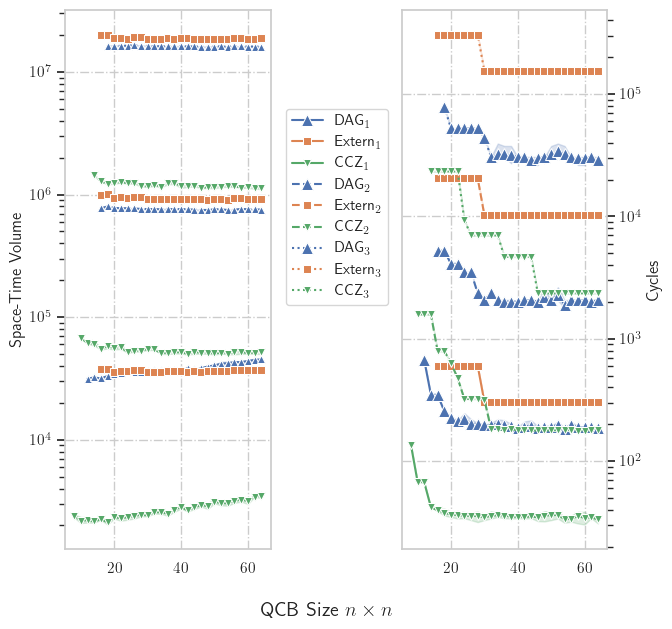

In [10]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

#f, ax = plt.subplots(figsize=(7, 7))


sbs.set_theme()
sbs.set_style("dark")
sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

#locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=20)  
#ax.yaxis.set_minor_locator(locmin)
#ax.yaxis.set_minor_formatter(mticker.NullFormatter())
#plt.grid(True,which="both")  


marks = ['', '.', 'x', '*']
linestyles = ['-', '--', ':']

target_label = 'distillation'
dependent = 'volume'
independent = 'height'
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))

ax = [
    plt.subplot2grid((1, 5), (0, 0), colspan=2),
    plt.subplot2grid((1, 5), (0, 3), colspan=2)
]

subplot = ax[0]
kwargs = {
'errorbar':('ci', 100)
}

for idx, target in enumerate((1, 2, 3)):
    sbs.lineplot(
        ax=subplot,
        **plt_data(
            results_dag[target_label],
            results_dag[independent],
            results_dag[dependent],
            target=target
        ),
        label=f'DAG$_{target}$',
        linestyle=linestyles[idx],
        marker='^',
        color=sbs.color_palette()[0],
        **kwargs
    )

    sbs.lineplot(
        ax=subplot,
        **plt_data(
            results_extern[target_label],
            results_extern[independent],
            results_extern[dependent],
            target=target
        ),
        label=f'Extern$_{target}$',
        linestyle=linestyles[idx],
        marker='s',
        color=sbs.color_palette()[1],
        **kwargs
    )

    obj = sbs.lineplot(
        ax=subplot,
        **plt_data(
            results_ccz['distillation'],
            results_ccz[independent],
            results_ccz[dependent],
            target=target
        ),
        label=f'CCZ$_{target}$',
        linestyle=linestyles[idx],
        marker='v',
        color=sbs.color_palette()[2],
        **kwargs
    )
subplot.legend_.remove()
subplot.yaxis.set_label_position("left")
subplot.yaxis.tick_left()
subplot.set_yscale('log')
subplot.set_ylabel('Space-Time Volume')

dependent = 'runtime'
independent = 'height'
subplot = ax[1]
for idx, target in enumerate((1, 2, 3)):
    sbs.lineplot(
        ax=subplot,
        **plt_data(
            results_dag['distillation'],
            results_dag[independent],
            results_dag[dependent],
            target=target
        ),
        label=f'DAG$_{target}$',
        linestyle=linestyles[idx],
        marker='^',
        markersize=9,
        color=sbs.color_palette()[0],
        **kwargs
    )

    sbs.lineplot(
        ax=subplot,
        **plt_data(
            results_extern['distillation'],
            results_extern[independent],
            results_extern[dependent],
            target=target
        ),
        label=f'Extern$_{target}$',
        linestyle=linestyles[idx],
        marker='s',
        color=sbs.color_palette()[1],
        **kwargs
    )

    obj = sbs.lineplot(
        ax=subplot,
        **plt_data(
            results_ccz['distillation'],
            results_ccz[independent],
            results_ccz[dependent],
            target=target
        ),
        label=f'CCZ$_{target}$',
        linestyle=linestyles[idx],
        marker='v',
        color=sbs.color_palette()[2],
        **kwargs
    )
    
subplot.legend_.remove()
subplot.yaxis.set_label_position("right")
subplot.yaxis.tick_right()
subplot.set_yscale('log')
subplot.set_ylabel('Cycles')

fig = plt.gcf()
fig.set_size_inches(7, 7)

lines = linestyles * 3
labels = sum(([f'DAG$_{target}$', f'Extern$_{target}$', f'CCZ$_{target}$'] for target in range(3)), start=list())

handles, labels = subplot.get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper left', bbox_to_anchor=(0.43, 0.75))
fig.supxlabel('QCB Size $n \\times n$')


#sbs.lineplot(x=results_extern['n_ctrl'], y=results_extern['volume'], label="Toffoli Extern")
#sbs.lineplot(x=results_ccz['n_ctrl'], y=results_ccz['volume'], label='Toffoli Factory', **ccz_style, marker='^')


#plt.title('Toffoli Runtimes for Various QCB Sizes')
#plt.xlabel('C$^{n}$X')
#plt.ylabel('Space-Time Volume')

#plt.yscale('log')

#plt.legend()

plt.savefig('toffoli_network.pdf')

NameError: name 'results_base' is not defined

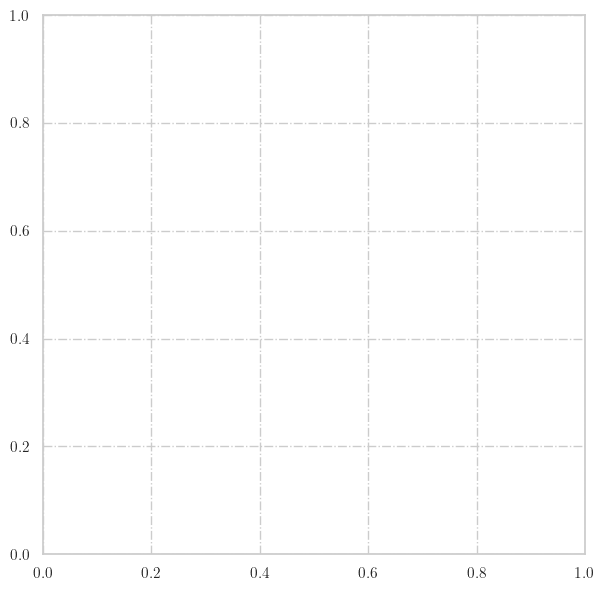

In [9]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

f, ax = plt.subplots(figsize=(7, 7))


sbs.set_theme()
sbs.set_style("dark")
sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

#locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=20)  
#ax.yaxis.set_minor_locator(locmin)
#ax.yaxis.set_minor_formatter(mticker.NullFormatter())
plt.grid(True,which="both")  

marks = ['', '.', 'x', '*']
linestyles = ['-', '--', ':']


ccz_style = {'linestyle': '--'}

sbs.lineplot(x=results_base['height'], y=results_base['volume'], label="Decomposed DAG")
sbs.lineplot(x=results_ccz_10['height'], y=results_ccz_10['volume'], label='CCZ $10 \\times 10$', **ccz_style, marker='^')
sbs.lineplot(x=results_ccz_20['height'], y=results_ccz_20['volume'], label='CCZ $20 \\times 20$', **ccz_style, marker="v")

sbs.lineplot(x=results_extern_10['height'], y=results_extern_10['volume'], label="Extern $10 \\times 10$", marker='^')
sbs.lineplot(x=results_extern_20['height'], y=results_extern_20['volume'], label="Extern $20 \\times 20$", marker='v')

#plt.title('Toffoli Runtimes for Various QCB Sizes')
plt.xlabel('QCB Size $n \\times n$')
plt.ylabel('Space-Time Volume')

#plt.yscale('log')

#plt.legend()

#plt.savefig('toffoli.pdf')

Text(0, 0.5, 'Space-Time Volume')

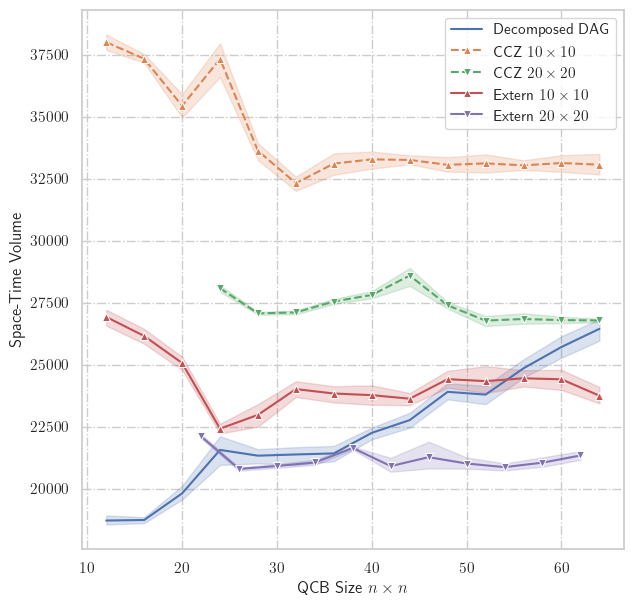

In [85]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

f, ax = plt.subplots(figsize=(7, 7))

sbs.set_theme()
sbs.set_style("dark")
sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

#locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=20)  
#ax.yaxis.set_minor_locator(locmin)
#ax.yaxis.set_minor_formatter(mticker.NullFormatter())
plt.grid(True,which="both")  

marks = ['', '.', 'x', '*']
linestyles = ['-', '--', ':']

ccz_style = {'linestyle': '--'}

sbs.lineplot(x=results_base['height'], y=results_base['volume'], label="Decomposed DAG")
sbs.lineplot(x=results_ccz_10['height'], y=results_ccz_10['volume'], label='CCZ $10 \\times 10$', **ccz_style, marker='^')
sbs.lineplot(x=results_ccz_20['height'], y=results_ccz_20['volume'], label='CCZ $20 \\times 20$', **ccz_style, marker="v")

sbs.lineplot(x=results_extern_10['height'], y=results_extern_10['volume'], label="Extern $10 \\times 10$", marker='^')
sbs.lineplot(x=results_extern_20['height'], y=results_extern_20['volume'], label="Extern $20 \\times 20$", marker='v')

#plt.title('Toffoli Runtimes for Various QCB Sizes')

plt.xlabel('QCB Size $n \\times n$')
plt.ylabel('Space-Time Volume')

#plt.yscale('log')
#plt.legend()
#plt.savefig('toffoli.pdf')

Text(0, 0.5, 'Cycles')

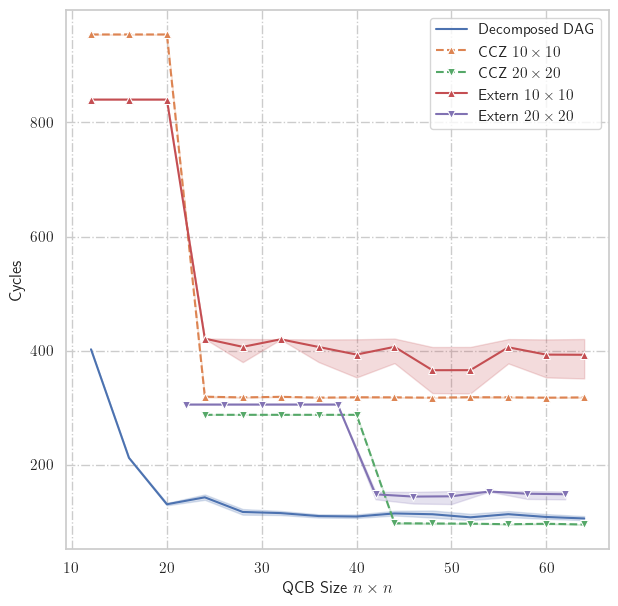

In [86]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

f, ax = plt.subplots(figsize=(7, 7))


sbs.set_theme()
sbs.set_style("dark")
sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

#locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=20)  
#ax.yaxis.set_minor_locator(locmin)
#ax.yaxis.set_minor_formatter(mticker.NullFormatter())
plt.grid(True,which="both")  


marks = ['', '.', 'x', '*']
linestyles = ['-', '--', ':']


ccz_style = {'linestyle': '--'}

sbs.lineplot(x=results_base['height'], y=results_base['runtime'], label="Decomposed DAG")
sbs.lineplot(x=results_ccz_10['height'], y=results_ccz_10['runtime'], label='CCZ $10 \\times 10$', **ccz_style, marker='^')
sbs.lineplot(x=results_ccz_20['height'], y=results_ccz_20['runtime'], label='CCZ $20 \\times 20$', **ccz_style, marker="v")

sbs.lineplot(x=results_extern_10['height'], y=results_extern_10['runtime'], label="Extern $10 \\times 10$", marker='^')
sbs.lineplot(x=results_extern_20['height'], y=results_extern_20['runtime'], label="Extern $20 \\times 20$", marker='v')

#plt.title('Toffoli Runtimes for Various QCB Sizes')
plt.xlabel('QCB Size $n \\times n$')
plt.ylabel('Cycles')

#plt.yscale('log')

#plt.legend()

#plt.savefig('toffoli.pdf')